[INFO] Stitching with Feather blending...
[INFO] Stitching with Linear blending...
[INFO] Stitching with Multiband blending...


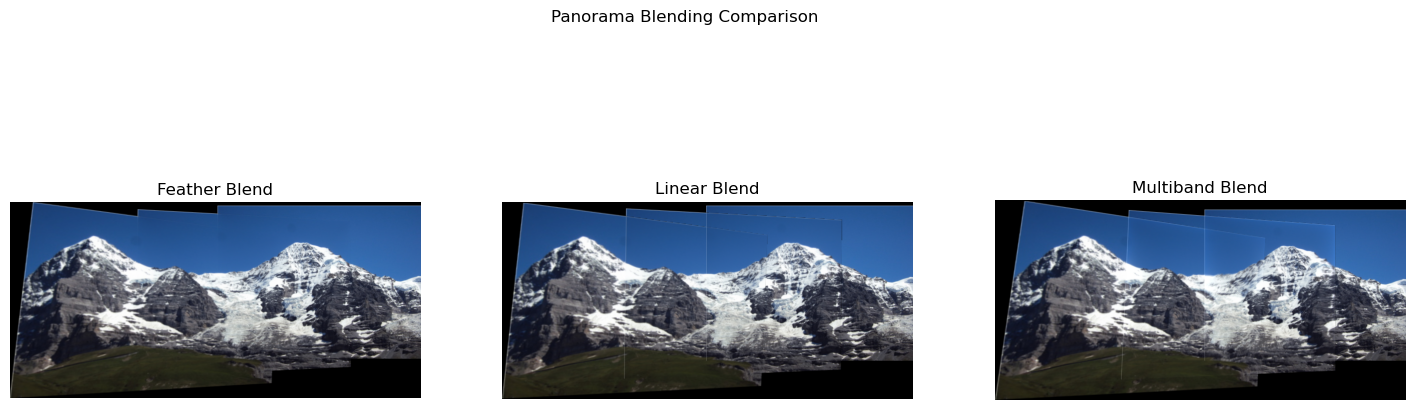

In [9]:
import cv2
import numpy as np
import os
import random
from matplotlib import pyplot as plt

# load images from the folder
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        path = os.path.join(folder, filename)
        if os.path.isfile(path):
            img = cv2.imread(path)
            if img is not None:
                images.append(img)
    return images

# the sift
sift = cv2.SIFT_create()

# ============ 3. Homography w/ RANSAC ============
def compute_homography(p1, p2):
    A = []
    for i in range(len(p1)):
        x, y = p1[i]
        u, v = p2[i]
        A.append([-x, -y, -1, 0, 0, 0, x*u, y*u, u])
        A.append([0, 0, 0, -x, -y, -1, x*v, y*v, v])
    A = np.asarray(A)
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3,3)
    return H / H[-1,-1]

def ransac_homography(pts1, pts2, threshold=2.0, iterations=2000):
    max_inliers = []
    best_H = None
    num_pts = len(pts1)
    idx_all = list(range(num_pts))

    for _ in range(iterations):
        sample = random.sample(idx_all, 4)
        p1_s = pts1[sample]
        p2_s = pts2[sample]
        H_cand = compute_homography(p1_s, p2_s)

        # Project
        pts1_hom = np.hstack([pts1, np.ones((num_pts,1))])
        proj = (H_cand @ pts1_hom.T).T
        proj /= proj[:, [2]]

        errors = np.linalg.norm(proj[:,:2] - pts2, axis=1)
        inliers = errors < threshold
        if np.sum(inliers) > np.sum(max_inliers):
            max_inliers = inliers
            best_H = H_cand

    return best_H, max_inliers

# ============ 4. Blending Methods ===============

def feather_blend(base, overlay, mask_base, mask_overlay):
    base_f = base.astype(np.float32)
    over_f = overlay.astype(np.float32)

    dist_base = cv2.distanceTransform(mask_base, cv2.DIST_L2, 3)
    dist_over = cv2.distanceTransform(mask_overlay, cv2.DIST_L2, 3)
    dist_sum = dist_base + dist_over + 1e-5
    alpha = dist_base / dist_sum

    alpha_3 = np.dstack([alpha]*3)
    blended_overlap = base_f * alpha_3 + over_f*(1-alpha_3)
    blended_overlap = blended_overlap.astype(np.uint8)

    out = np.zeros_like(base)
    only_base = (mask_base==255)&(mask_overlay==0)
    only_over = (mask_overlay==255)&(mask_base==0)
    overlap = (mask_base==255)&(mask_overlay==255)

    out[only_base] = base[only_base]
    out[only_over] = overlay[only_over]
    out[overlap] = blended_overlap[overlap]
    return out

def linear_blend(base, overlay, mask_base, mask_overlay):
    base_f = base.astype(np.float32)
    over_f = overlay.astype(np.float32)
    alpha = 0.5
    overlap = (mask_base==255)&(mask_overlay==255)
    only_base = (mask_base==255)&(mask_overlay==0)
    only_over = (mask_overlay==255)&(mask_base==0)

    out = np.zeros_like(base)
    out[only_base] = base[only_base]
    out[only_over] = overlay[only_over]

    blended_overlap = (alpha * base_f + (1-alpha)*over_f).astype(np.uint8)
    out[overlap] = blended_overlap[overlap]
    return out

# Insert the simpler robust multiband_blend function here:
# (exactly as shown above)
# ---------------------------------------------------------------------
def multiband_blend(base, overlay, mask_base, mask_overlay, num_bands=5):
    """
    Multiband blending using a 'fraction mask' to avoid shape mismatches.
    """
    # Force same minimal size
    H = min(base.shape[0], overlay.shape[0])
    W = min(base.shape[1], overlay.shape[1])
    base = base[:H, :W]
    overlay = overlay[:H, :W]
    mask_base = mask_base[:H, :W]
    mask_overlay = mask_overlay[:H, :W]

    # fraction mask
    base_f = base.astype(np.float32)/255.0
    over_f = overlay.astype(np.float32)/255.0
    mb = mask_base.astype(np.float32)
    mo = mask_overlay.astype(np.float32)
    den = mb + mo + 1e-5
    frac = mb / den  # single-channel [0..1]

    # Build Gaussian pyramids
    gauss_base = [base_f]
    gauss_over = [over_f]
    gauss_frac = [frac]
    for _ in range(num_bands):
        gauss_base.append(cv2.pyrDown(gauss_base[-1]))
        gauss_over.append(cv2.pyrDown(gauss_over[-1]))
        gauss_frac.append(cv2.pyrDown(gauss_frac[-1]))

    # Build Laplacian pyramids
    lap_base = []
    lap_over = []
    for i in range(num_bands):
        up_b = cv2.pyrUp(gauss_base[i+1], dstsize=(gauss_base[i].shape[1], gauss_base[i].shape[0]))
        lap_base.append(gauss_base[i] - up_b)
        up_o = cv2.pyrUp(gauss_over[i+1], dstsize=(gauss_over[i].shape[1], gauss_over[i].shape[0]))
        lap_over.append(gauss_over[i] - up_o)
    lap_base.append(gauss_base[-1])
    lap_over.append(gauss_over[-1])

    # Blend each level using frac
    blended_pyr = []
    for i in range(num_bands+1):
        frac_i = gauss_frac[i]
        if len(frac_i.shape)==2:  
            frac_i = frac_i[..., None]
        if frac_i.shape[2]==1:
            frac_i = np.repeat(frac_i, 3, axis=2)

        lbase = lap_base[i]
        lover = lap_over[i]
        blend_lvl = lbase*frac_i + lover*(1-frac_i)
        blended_pyr.append(blend_lvl)

    # Reconstruct
    blended = blended_pyr[-1]
    for i in range(num_bands-1, -1, -1):
        up_b = cv2.pyrUp(blended, dstsize=(blended_pyr[i].shape[1], blended_pyr[i].shape[0]))
        blended = blended_pyr[i] + up_b

    blended = np.clip(blended*255.0, 0, 255).astype(np.uint8)

    # Final composite
    out = np.zeros_like(base, dtype=np.uint8)
    only_base = (mask_base==255)&(mask_overlay==0)
    only_over = (mask_overlay==255)&(mask_base==0)
    overlap = (mask_base==255)&(mask_overlay==255)
    out[only_base] = base[only_base]
    out[only_over] = overlay[only_over]
    out[overlap] = blended[overlap]
    return out
# ---------------------------------------------------------------------

# ============ 5. Warping + Blend Wrapper =============

def custom_warp_perspective(base_image, next_image, H, blend_method="feather"):
    h1, w1 = base_image.shape[:2]
    h2, w2 = next_image.shape[:2]

    # Warp corners to find bounding box
    corners1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    corners2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    warped_corners = cv2.perspectiveTransform(corners1, H)
    all_corners = np.concatenate((warped_corners, corners2), axis=0)

    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    trans = [-x_min, -y_min]
    T = np.array([[1,0,trans[0]],[0,1,trans[1]],[0,0,1]], dtype=np.float32)

    # Warp the base image
    panorama = cv2.warpPerspective(base_image, T@H, (x_max - x_min, y_max - y_min))

    # Overlay
    overlay = np.zeros_like(panorama)
    overlay[trans[1]:trans[1]+h2, trans[0]:trans[0]+w2] = next_image

    mask_base = (panorama.sum(axis=2)>0).astype(np.uint8)*255
    mask_over = (overlay.sum(axis=2)>0).astype(np.uint8)*255

    if blend_method=="feather":
        blended = feather_blend(panorama, overlay, mask_base, mask_over)
    elif blend_method=="linear":
        blended = linear_blend(panorama, overlay, mask_base, mask_over)
    elif blend_method=="multiband":
        blended = multiband_blend(panorama, overlay, mask_base, mask_over, num_bands=5)
    else:
        print(f"[WARN] Unknown blend method '{blend_method}'. Defaulting to feather.")
        blended = feather_blend(panorama, overlay, mask_base, mask_over)

    return blended

# ============ 6. Stitching Pipeline ================

def stitch_images(images, blend_method="feather"):
    panorama = images[0]
    for i in range(1, len(images)):
        gray1 = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)

        kpts1, desc1 = sift.detectAndCompute(gray1, None)
        kpts2, desc2 = sift.detectAndCompute(gray2, None)
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(desc1, desc2, k=2)

        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append(m)
        if len(good)<4:
            print("[WARN] Not enough matches for image", i)
            continue

        pts1 = np.float32([kpts1[m.queryIdx].pt for m in good])
        pts2 = np.float32([kpts2[m.trainIdx].pt for m in good])

        H, _ = ransac_homography(pts1, pts2, threshold=3, iterations=2000)
        panorama = custom_warp_perspective(panorama, images[i], H, blend_method=blend_method)

    return panorama

# ============== 7. Main Execution ================
if __name__=="__main__":
    folder = "images"  # Update with your folder path
    images = load_images_from_folder(folder)
    if len(images)<2:
        print("Need at least two images to stitch.")
        exit()

    print("[INFO] Stitching with Feather blending...")
    stitched_feather = stitch_images(images, blend_method="feather")

    print("[INFO] Stitching with Linear blending...")
    stitched_linear = stitch_images(images, blend_method="linear")

    print("[INFO] Stitching with Multiband blending...")
    stitched_multiband = stitch_images(images, blend_method="multiband")

    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(stitched_feather, cv2.COLOR_BGR2RGB))
    plt.title("Feather Blend")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(cv2.cvtColor(stitched_linear, cv2.COLOR_BGR2RGB))
    plt.title("Linear Blend")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(stitched_multiband, cv2.COLOR_BGR2RGB))
    plt.title("Multiband Blend")
    plt.axis('off')

    plt.suptitle("Panorama Blending Comparison")
    plt.show()
